In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

device = get_free_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
current device cuda:15


In [6]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [7]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

In [8]:

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
top_k_file_sum2atom = experiment_folder + "top-k/bottleneck_topkinds_sum2atom_seed_{seed}.csv"
top_k_file_sum2con = experiment_folder + "top-k/bottleneck_topkinds_sum2con_seed_{seed}.csv"
makedir(top_k_file_sum2atom)

random_seeds = range(1,4)


27 8 6


## Optimization Atomics

In [9]:
def get_model_sum2con(random_seed):
    set_seed(random_seed)
    
    config = {
        "n_atomics": 10, # 30
        "n_concepts": 4, # 20
        "use_summaries_for_atomics": False,
    }

    makedir(experiment_folder)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    
    model = models_3d_atomics.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, device=device)
    model_path = model.get_model_path(experiment_folder, dataset="mimic", pruning="importance", seed=random_seed)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path, max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model_sum2con = get_model_sum2con(1)

def get_model_sum2atom(random_seed):
    set_seed(random_seed)
    
    config = {
        "n_atomics": 10, # 30
        "n_concepts": 4, # 20
        "use_summaries_for_atomics": True,
    }

    makedir(experiment_folder)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    
    model = models_3d_atomics.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, device=device)
    model_path = model.get_model_path(experiment_folder, dataset="mimic", pruning="importance", seed=random_seed)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path, max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model_sum2atom = get_model_sum2atom(1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 1/10000 [00:02<8:14:10,  2.97s/ epoch, Train Loss=0.77872, Val Loss=0.73972, Best Val Loss=0.73972]

  4%|▍         | 380/10000 [08:10<3:26:53,  1.29s/ epoch, Train Loss=0.55163, Val Loss=0.57366, Best Val Loss=0.57321]

Early Stopped


AUC macro 0.903
ACC macro 0.858
 F1 macro 0.862


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  9%|▉         | 910/10000 [19:07<3:11:00,  1.26s/ epoch, Train Loss=0.49863, Val Loss=0.53715, Best Val Loss=0.53624]

Early Stopped


AUC macro 0.917
ACC macro 0.844
 F1 macro 0.851


In [8]:
models = [get_model_sum2atom(random_seed) for random_seed in random_seeds]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_summaries_for_atomics_True_seed_1.pt
AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 3/10000 [00:03<2:37:19,  1.06 epoch/s, Train Loss=0.66761, Val Loss=0.70064, Best Val Loss=0.70064]

  7%|▋         | 670/10000 [11:03<2:33:55,  1.01 epoch/s, Train Loss=0.50782, Val Loss=0.53006, Best Val Loss=0.52981]

Early Stopped


AUC macro 0.917
ACC macro 0.839
 F1 macro 0.847


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  7%|▋         | 710/10000 [10:17<2:14:35,  1.15 epoch/s, Train Loss=0.50904, Val Loss=0.51866, Best Val Loss=0.51727]

Early Stopped


AUC macro 0.920
ACC macro 0.842
 F1 macro 0.850


In [9]:
models = [get_model_sum2con(random_seed) for random_seed in random_seeds]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_summaries_for_atomics_False_seed_1.pt
AUC macro 0.904
ACC macro 0.852
 F1 macro 0.856


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 32/10000 [00:28<2:41:21,  1.03 epoch/s, Train Loss=0.59131, Val Loss=0.59354, Best Val Loss=0.59354]

  2%|▏         | 170/10000 [02:30<2:25:20,  1.13 epoch/s, Train Loss=0.57340, Val Loss=0.57612, Best Val Loss=0.56994]

Early Stopped


AUC macro 0.902
ACC macro 0.838
 F1 macro 0.844


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  2%|▎         | 250/10000 [03:39<2:22:43,  1.14 epoch/s, Train Loss=0.55730, Val Loss=0.57634, Best Val Loss=0.56764]

Early Stopped


AUC macro 0.889
ACC macro 0.813
 F1 macro 0.824


In [10]:
def plot_metrics(metric_list, x_labels):
    # Unzip the list of tuples into separate lists
    auc, acc, f1 = zip(*metric_list)
    
    # Plot each metric
    x = range(len(x_labels))
    plt.plot(x, auc, label='AUC')
    plt.plot(x, acc, label='ACC')
    plt.plot(x, f1, label='F1')
    
    plt.xticks(x, labels=x_labels)
    
    # Add labels and legend
    plt.xlabel('Percentages')
    plt.ylabel('Metric Value')
    plt.title('Pruning')
    plt.legend()
    
    # Show plot
    plt.show()
    
def get_list_from_mask(mask):
    selected_list = [[] for _ in range(mask.shape[0])]
    for i, row in enumerate(mask):
        for j, value in enumerate(row):
            if value:
                selected_list[i].append(j)
    return selected_list

def plot_selected_weights(weight, selected_list, top_k=None, sorted=True, log_scale=True):
    abs_weight = weight.detach().cpu().numpy()
    abs_weight = np.abs(abs_weight)
    
    n_concepts = abs_weight.shape[0]
    max_y = np.max(abs_weight)
    
    fig, axs = plt.subplots(n_concepts, figsize=(8, 2 * n_concepts))
    
    for c in range(n_concepts):
        ax = axs[c]
        
        selected_list_idx = selected_list[c]
        if not selected_list_idx:
            continue
        
        min_weight = np.min(abs_weight[c][selected_list_idx])
        max_weight = np.max(abs_weight[c][selected_list_idx])
        
        if top_k is None:
            if sorted:
                weight_idx = np.argsort(-abs_weight[c])
            else:
                weight_idx = range(abs_weight.shape[1])
            
            weight_idx = weight_idx[abs_weight[c][weight_idx] >= min_weight]
        else:
            if sorted:
                weight_idx = np.argsort(-abs_weight[c])
            else:
                weight_idx = range(abs_weight.shape[1])
            
            top_k = min(top_k, abs_weight.shape[1])
            weight_idx = weight_idx[:top_k]
        
        n_rel_feat = len(weight_idx)
        
        def getColor(idx):
            if idx in selected_list_idx:
                return "red"
            else:
                return "gray"
        
        colors = [getColor(idx) for idx in weight_idx]
        ax.bar(np.arange(1, len(weight_idx)+1), abs_weight[c][weight_idx], color=colors)
        
        ax.set_title(f"Selected {len(selected_list_idx)}; of total {len(abs_weight[c])})")
        ax.set_xlabel(f"Top {n_rel_feat} features (descending by weight) (min={min_weight:.3f}) (max={max_weight:.3f})")
        ax.set_ylabel(f"Concept {c}")
        ax.set_ylim(0, max_y)
        if log_scale:
            ax.set_yscale('log')
        
        leg_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'blue', 'gray']]
        leg_labels = ["Selected", "Initialization", "Neither"]
        ax.legend(leg_handles, leg_labels)
    
    # plt.ylabel("abs value of feature coefficient")
    plt.tight_layout()
    plt.show()



In [13]:
for random_seed in [1]:
    model = get_model_sum2atom(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    metric_list = []
    
    start_n_weights = [layer.weight.numel() for layer in model.regularized_layers]
    end_n_weights = [layer.weight.shape[0] * 10 for layer in model.regularized_layers] # feature budget
    
    iterative_steps = [list(np.linspace(start, end, 11, dtype=int))[1:] for start, end in zip(start_n_weights, end_n_weights)]
    print(iterative_steps)
    
    # fill ema gradient by fit -> repeat: mask, clear, fit, evaluate
    model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=1, save_every_n_epochs=1, patience=1)
    
    for step in zip(*iterative_steps):
        model.mask_by_gradient_magnitude(step)
        model.clear_ema_gradient()
        model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
        metrics = evaluate_classification(model, val_loader)
        metric_list.append(metrics)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/mimic/atomics/importance/atomics_num_concepts_4_num_atomics_10_use_summaries_for_atomics_True_use_indicators_True_seed_1.pt
AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844
[[298, 276, 254, 232, 210, 188, 166, 144, 122, 100], [976, 872, 768, 664, 560, 456, 352, 248, 144, 40]]


  3%|▎         | 3/100 [00:04<02:40,  1.66s/ epoch, Train Loss=0.54308, Val Loss=0.57234, Best Val Loss=0.57234]

100%|██████████| 100/100 [02:47<00:00,  1.68s/ epoch, Train Loss=0.52014, Val Loss=0.55339, Best Val Loss=0.55339]


AUC macro 0.909
ACC macro 0.833
 F1 macro 0.840


 63%|██████▎   | 63/100 [01:47<01:03,  1.71s/ epoch, Train Loss=0.51156, Val Loss=0.54089, Best Val Loss=0.54073]

Early Stopped


AUC macro 0.917
ACC macro 0.845
 F1 macro 0.851


100%|██████████| 100/100 [02:48<00:00,  1.69s/ epoch, Train Loss=0.51825, Val Loss=0.54113, Best Val Loss=0.54113]


AUC macro 0.910
ACC macro 0.834
 F1 macro 0.841


100%|██████████| 100/100 [02:47<00:00,  1.67s/ epoch, Train Loss=0.51452, Val Loss=0.54741, Best Val Loss=0.54594]


AUC macro 0.914
ACC macro 0.840
 F1 macro 0.846


100%|██████████| 100/100 [02:49<00:00,  1.69s/ epoch, Train Loss=0.51381, Val Loss=0.54216, Best Val Loss=0.54184]


AUC macro 0.914
ACC macro 0.838
 F1 macro 0.845


100%|██████████| 100/100 [02:49<00:00,  1.69s/ epoch, Train Loss=0.50903, Val Loss=0.53895, Best Val Loss=0.53662]


AUC macro 0.916
ACC macro 0.845
 F1 macro 0.852


100%|██████████| 100/100 [02:46<00:00,  1.66s/ epoch, Train Loss=0.52210, Val Loss=0.54604, Best Val Loss=0.54604]


AUC macro 0.911
ACC macro 0.835
 F1 macro 0.842


100%|██████████| 100/100 [02:49<00:00,  1.70s/ epoch, Train Loss=0.52426, Val Loss=0.54674, Best Val Loss=0.54669]


AUC macro 0.911
ACC macro 0.837
 F1 macro 0.846


100%|██████████| 100/100 [02:48<00:00,  1.68s/ epoch, Train Loss=0.53759, Val Loss=0.56019, Best Val Loss=0.56019]


AUC macro 0.903
ACC macro 0.833
 F1 macro 0.841


100%|██████████| 100/100 [02:48<00:00,  1.69s/ epoch, Train Loss=0.55310, Val Loss=0.56995, Best Val Loss=0.56995]


AUC macro 0.905
ACC macro 0.845
 F1 macro 0.851


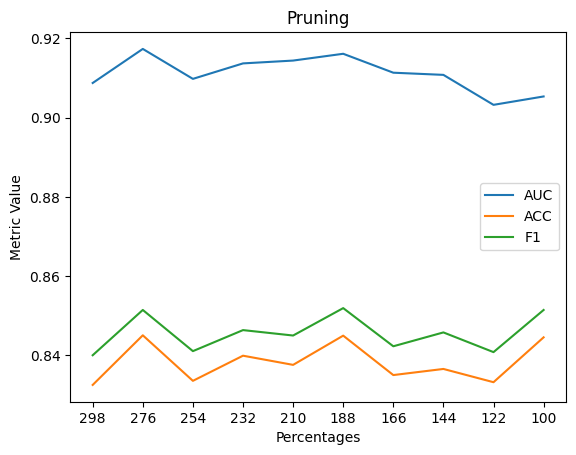

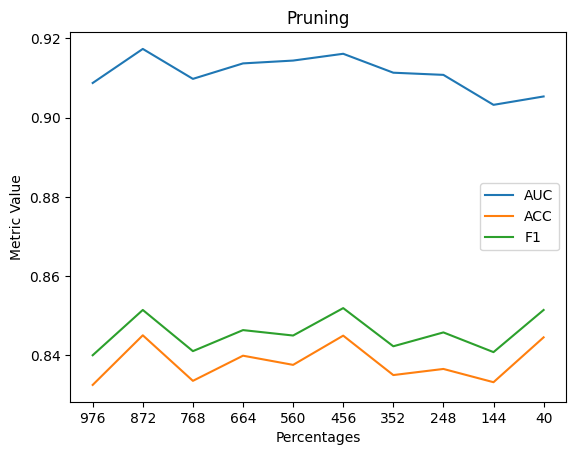

In [14]:
plot_metrics(metric_list, iterative_steps[0])
plot_metrics(metric_list, iterative_steps[1])


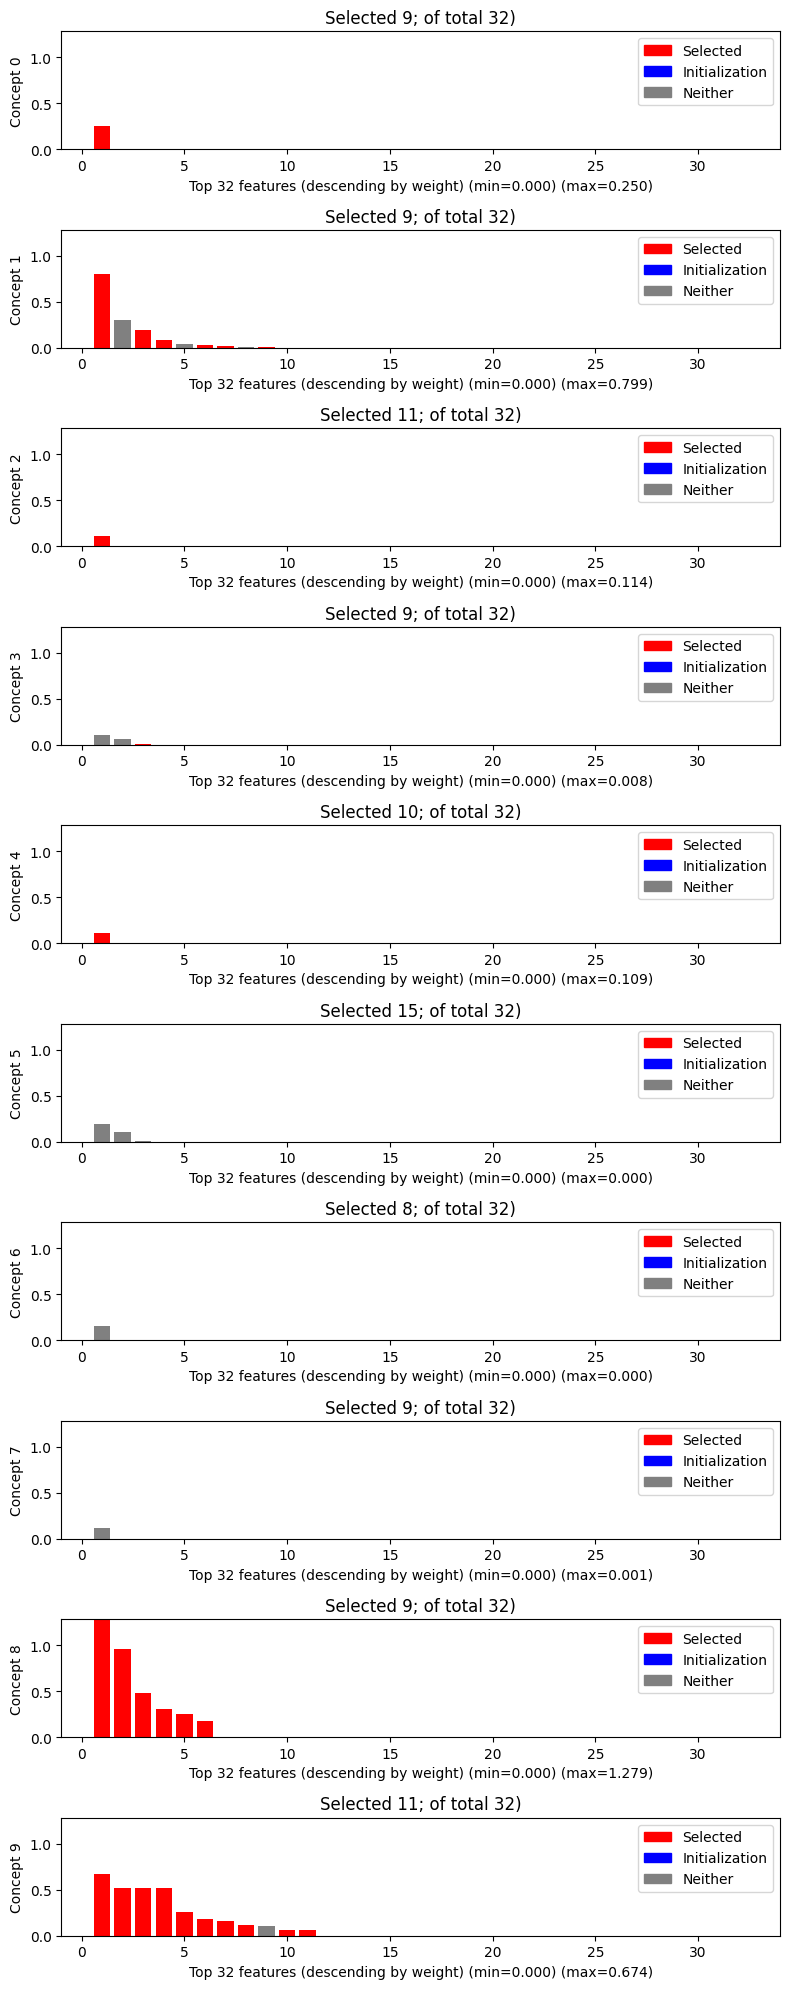

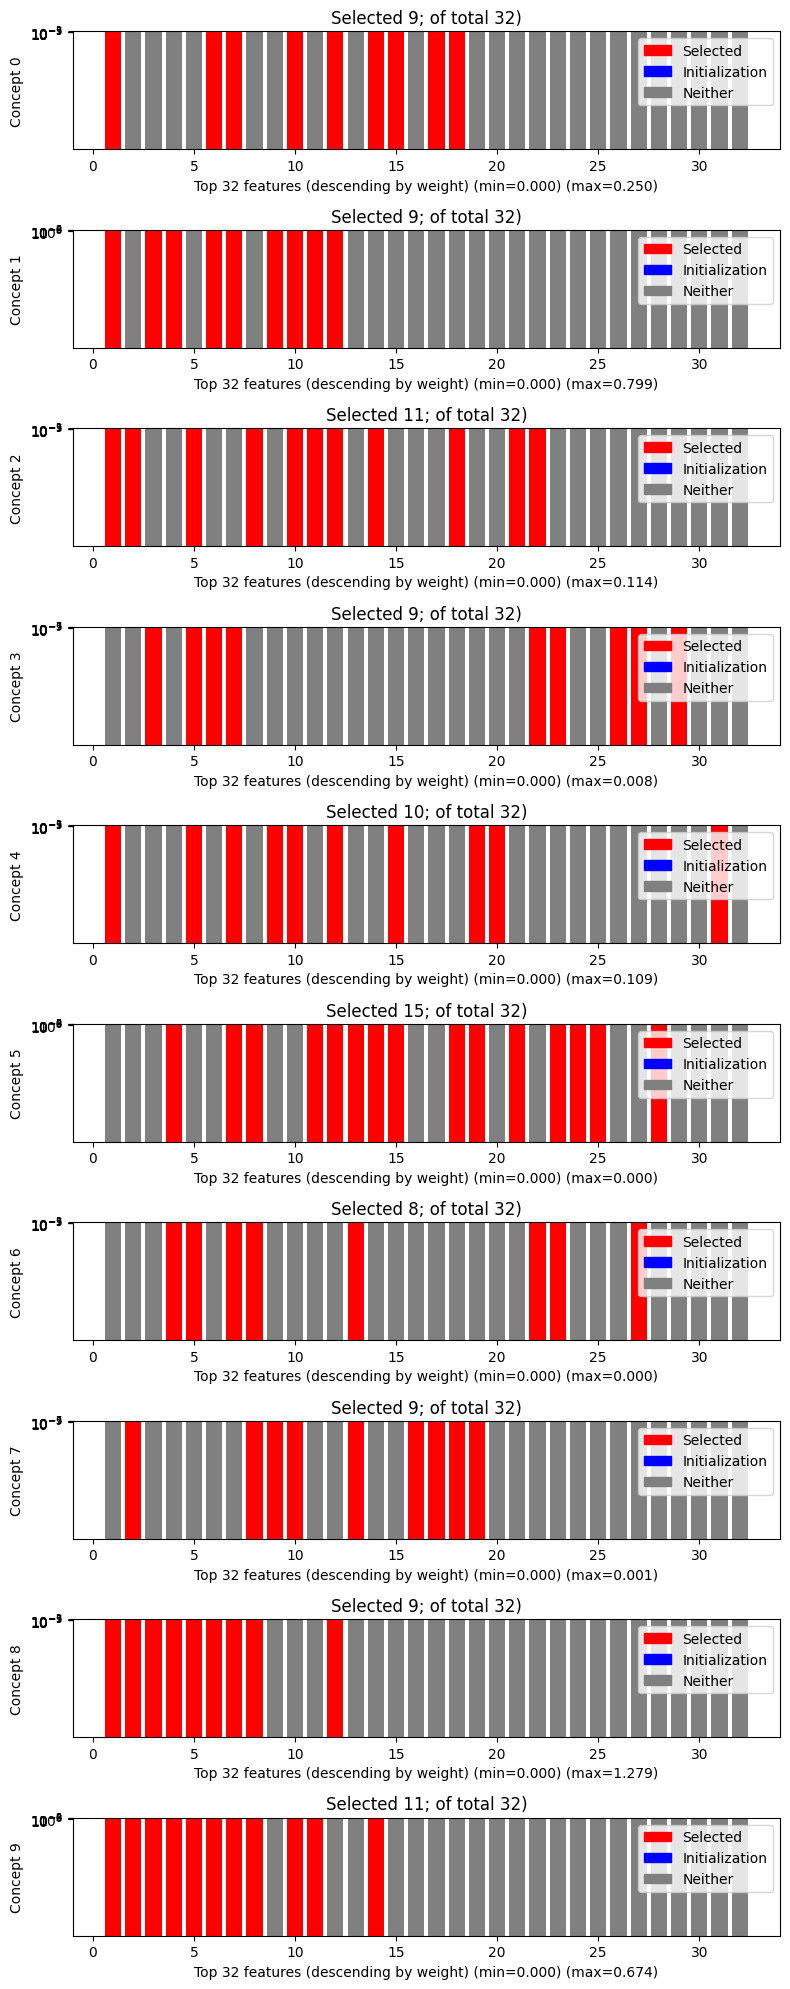

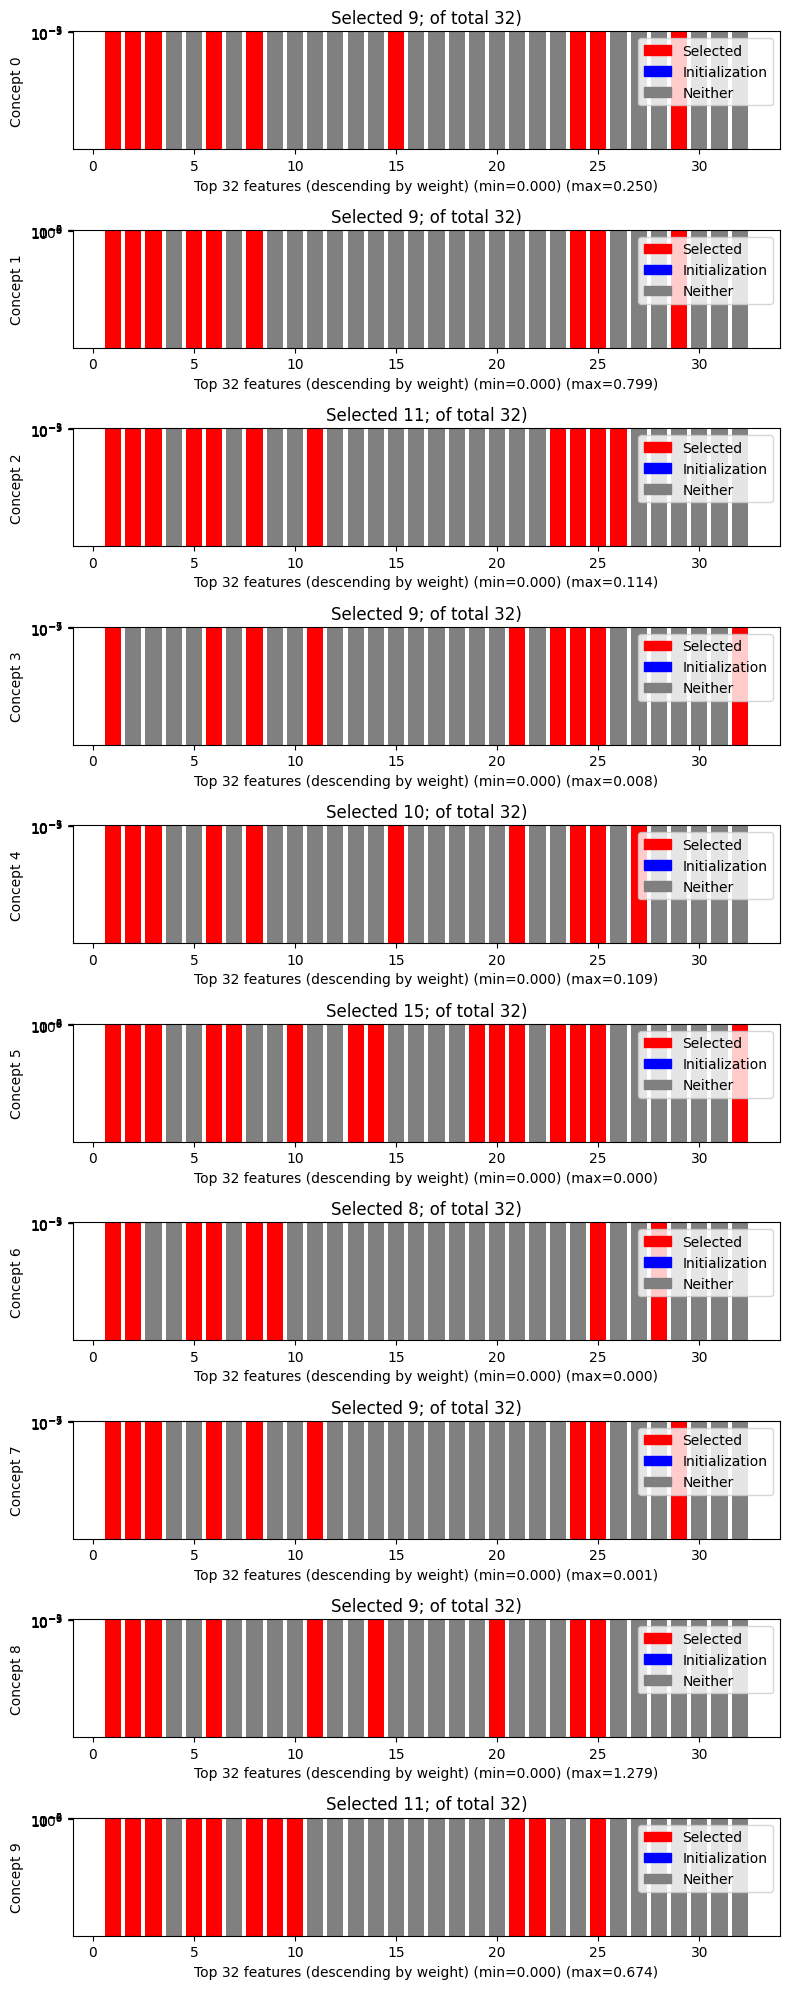

NEEXXXTTTTT
NEEXXXTTTTT


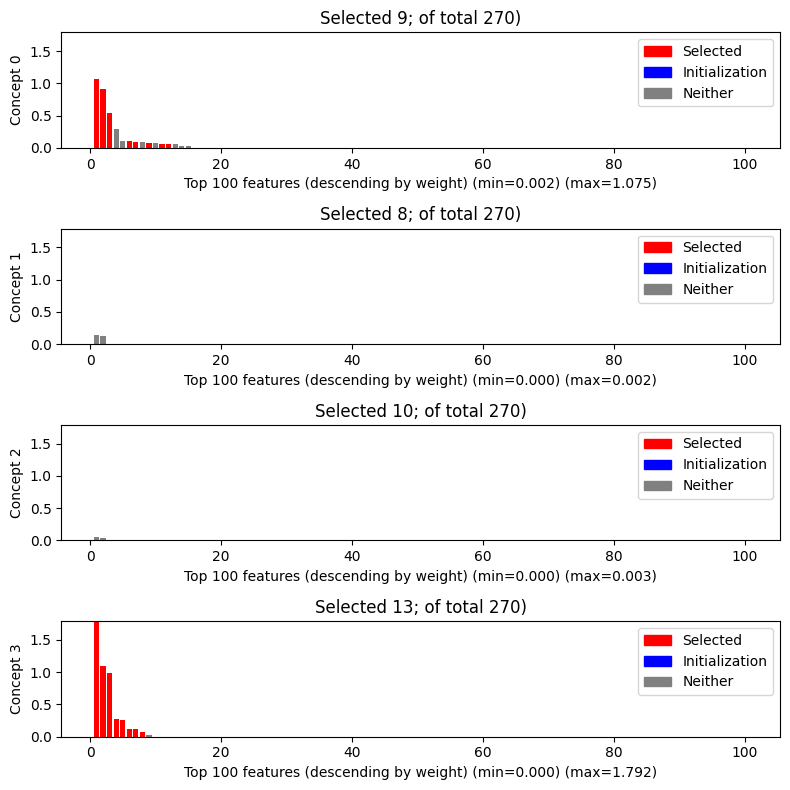

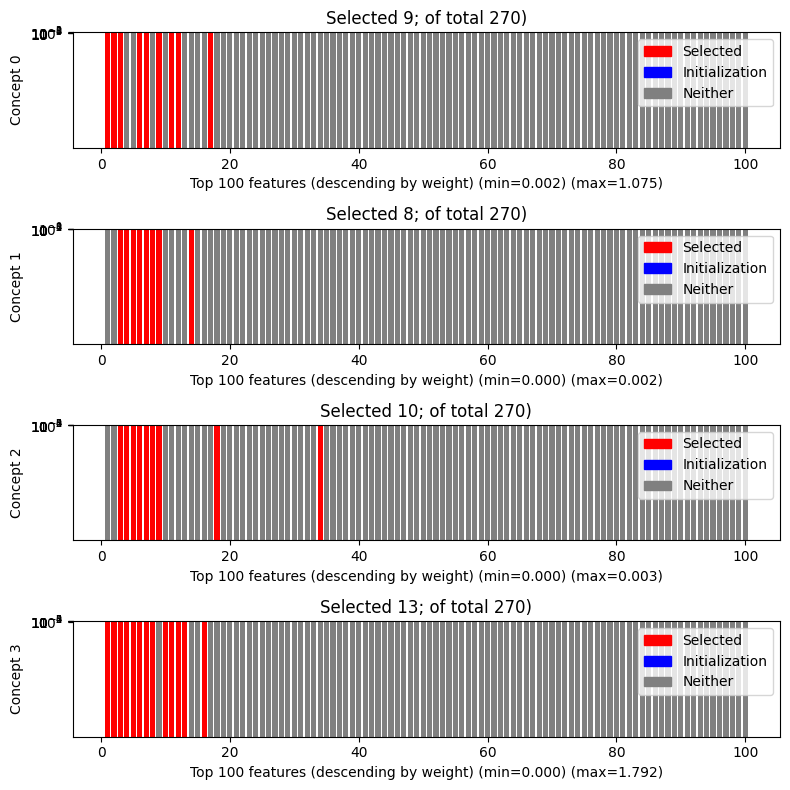

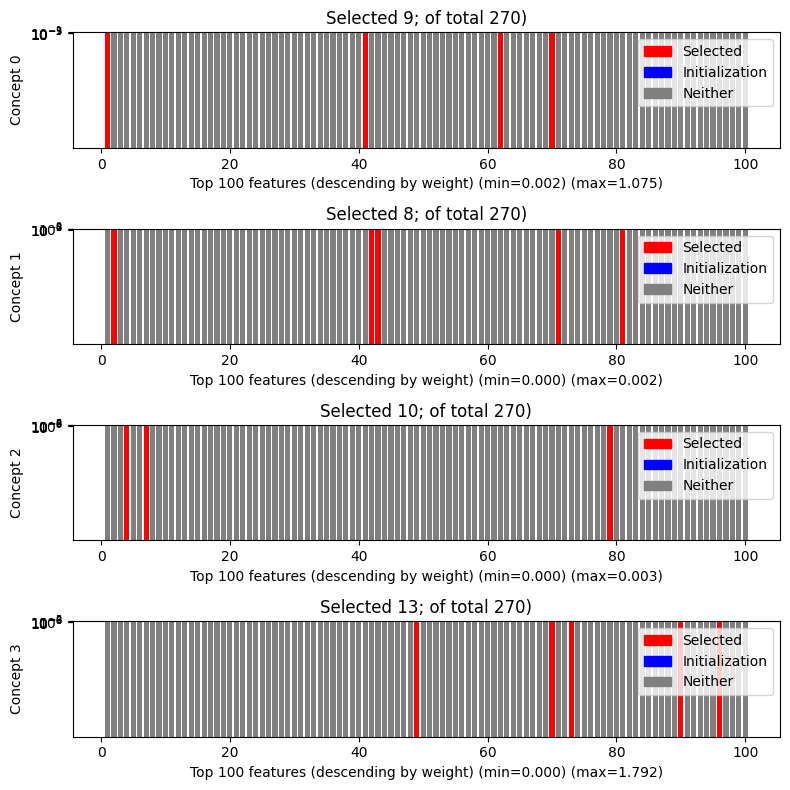

NEEXXXTTTTT
NEEXXXTTTTT


In [15]:
for layer in model.regularized_layers:
    selected_list = get_list_from_mask(layer.weight_mask)
    plot_selected_weights(layer.weight, selected_list, top_k=100, log_scale=False)
    plot_selected_weights(layer.weight, selected_list, top_k=100)
    plot_selected_weights(layer.weight, selected_list, top_k=100, sorted=False)
    print("NEEXXXTTTTT")
    print("NEEXXXTTTTT")
    

In [ ]:
for random_seed in [1]:
    model = get_model_sum2con(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    metric_list = []
    
    start_n_weights = [layer.weight.numel() for layer in model.regularized_layers]
    end_n_weights = [layer.weight.shape[0] * 10 for layer in model.regularized_layers] # feature budget
    
    iterative_steps = [list(np.linspace(start, end, 11, dtype=int))[1:] for start, end in zip(start_n_weights, end_n_weights)]
    print(iterative_steps)
    
    # fill ema gradient by fit -> repeat: mask, clear, fit, evaluate
    model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=1, save_every_n_epochs=1, patience=1)
    
    for step in zip(*iterative_steps):
        model.mask_by_gradient_magnitude(step)
        print(model.bottleneck.weight_mask.numel(), model.bottleneck.weight_mask.sum(), step)
        print(model.bottleneck.ema_gradient.sum(), "should be something")
        model.clear_ema_gradient()
        model.fit(train_loader, val_loader, p_weight=class_weights, save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
        metrics = evaluate_classification(model, val_loader)
        metric_list.append(metrics)

plot_metrics(metric_list, iterative_steps[0])
selected_list = get_list_from_mask(model.bottleneck.weight_mask)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, log_scale=False)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100)
plot_selected_weights(model.bottleneck.weight, selected_list, top_k=100, sorted=False)


In [10]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

results = []
for random_seed in random_seeds:
    print("random_seed", random_seed)
    model = get_model_sum2atom(random_seed)
    top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
    
    save_path = top_k_file_sum2atom.format(seed=random_seed)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, track_metrics=track_metrics, save_path=save_path)
    results.append(greedy_results)
    

random_seed 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_summaries_for_atomics_True_seed_1.pt
AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844
Found 10 Concepts
90th percentile per concept [0.17485653 0.11012712 0.15025544 0.733804   0.12479137 5.350915
 0.13964465 0.11854323 0.14277679 0.37324145]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 12', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [10.933439    0.19957875  0.18998273  0.17745395]
['Concept 0 len: 25', 'Concept 1 len: 136', 'Concept 2 len: 142', 'Concept 3 len: 133']


100%|██████████| 140/140 [8:24:27<00:00, 216.20s/it, Score=0.92484, acc=0.867, f1=0.87, auc=0.924]   


random_seed 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_summaries_for_atomics_True_seed_2.pt
AUC macro 0.914
ACC macro 0.835
 F1 macro 0.844
Found 10 Concepts
90th percentile per concept [0.10385152 0.11279983 0.13676858 1.1410556  4.170754   0.10808557
 0.13346706 0.1129206  0.1161652  0.12013048]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 11', 'Concept 5 len: 10', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [0.15444437 0.14113967 0.12406395 9.686562  ]
['Concept 0 len: 114', 'Concept 1 len: 95', 'Concept 2 len: 105', 'Concept 3 len: 24']


100%|██████████| 140/140 [6:43:23<00:00, 172.88s/it, Score=0.92627, acc=0.863, f1=0.863, auc=0.863]  


random_seed 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_summaries_for_atomics_True_seed_3.pt
AUC macro 0.916
ACC macro 0.832
 F1 macro 0.842
Found 10 Concepts
90th percentile per concept [0.10606434 0.15880544 0.11947753 0.9751971  5.232853   0.106959
 0.2346579  0.12774286 0.11593891 0.14114314]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 10', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [0.14629063 9.562573   0.11635866 2.4389155 ]
['Concept 0 len: 112', 'Concept 1 len: 26', 'Concept 2 len: 89', 'Concept 3 len: 10']


100%|██████████| 140/140 [4:40:53<00:00, 120.38s/it, Score=0.92663, acc=0.847, f1=0.855, auc=0.921]  


In [11]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

results = []
for random_seed in random_seeds:
    print("random_seed", random_seed)
    model = get_model_sum2con(random_seed)
    top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
    
    save_path = top_k_file_sum2con.format(seed=random_seed)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, track_metrics=track_metrics, save_path=save_path)
    results.append(greedy_results)
    

random_seed 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_summaries_for_atomics_False_seed_1.pt
AUC macro 0.904
ACC macro 0.852
 F1 macro 0.856
Found 10 Concepts
90th percentile per concept [0.1058721  0.09612118 0.08798857 0.08288713 0.11831457 0.10382091
 0.08240788 0.11732247 0.11612108 0.10727764]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 10', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [8.213496   5.385791   1.2535797  0.48202863]
['Concept 0 len: 46', 'Concept 1 len: 35', 'Concept 2 len: 111', 'Concept 3 len: 102']


 10%|█         | 14/140 [40:34<5:53:25, 168.30s/it, Score=0.91596, acc=0.86, f1=0.861, auc=0.916]

In [ ]:
result_df = evaluate_greedy_selection(get_model_sum2atom, get_MIMIC_dataloader, top_k_file_sum2atom, n_experiments=3)
result_df


In [ ]:
result_df = evaluate_greedy_selection(get_model_sum2con, get_MIMIC_dataloader, top_k_file_sum2con, n_experiments=3)
result_df


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_summaries_for_atomics_True_seed_1.pt
AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844
Validation set - Before Pruning
AUC macro 0.910
ACC macro 0.830
 F1 macro 0.838
Test set - Before Pruning
AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844
Test set - After Pruning
AUC macro 0.925
ACC macro 0.872
 F1 macro 0.874


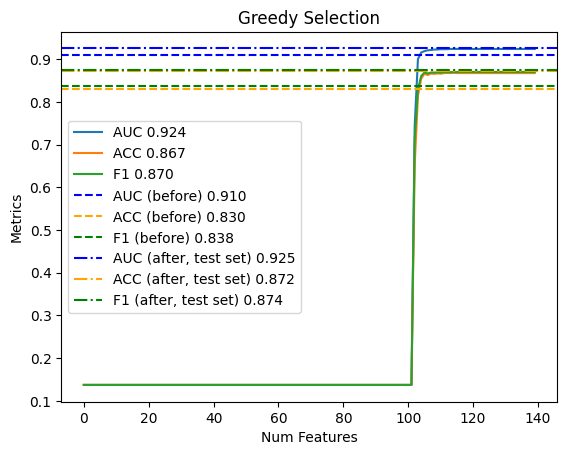

In [15]:
model = get_model_sum2atom(1)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds_sum2atom_seed_{seed}.csv").format(seed=seed)

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

visualize_optimization_results(model, val_loader, test_loader, greedy_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_summaries_for_atomics_True_seed_1.pt
AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844
AUC macro 0.925
ACC macro 0.872
 F1 macro 0.874


  4%|▍         | 410/10000 [06:26<2:30:38,  1.06 epoch/s, Train Loss=0.50331, Val Loss=0.52987, Best Val Loss=0.52978]

Early Stopped


AUC macro 0.917
ACC macro 0.846
 F1 macro 0.853


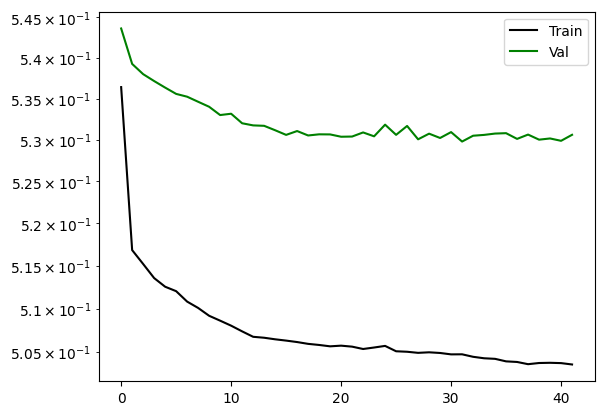

In [18]:
random_seed = 1
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds_sum2atom_seed_{seed}.csv").format(seed=seed)

model = get_model_sum2atom(random_seed)

model.deactivate_bottleneck_weights_if_top_k(greedy_results)

evaluate_classification(model, test_loader)

save_path = experiment_folder + "top-k/finetuned_sum2atom_seed_{seed}.pt".format(seed=random_seed)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=save_path, max_epochs=10000, patience=10)

evaluate_classification(model, test_loader)

plot_losses(model.train_losses, model.val_losses)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_summaries_for_atomics_False_seed_1.pt


AUC macro 0.900
ACC macro 0.860
 F1 macro 0.862
Validation set - Before Pruning
AUC macro 0.896
ACC macro 0.859
 F1 macro 0.861
Test set - Before Pruning
AUC macro 0.900
ACC macro 0.860
 F1 macro 0.862
Test set - After Pruning
AUC macro 0.894
ACC macro 0.862
 F1 macro 0.862


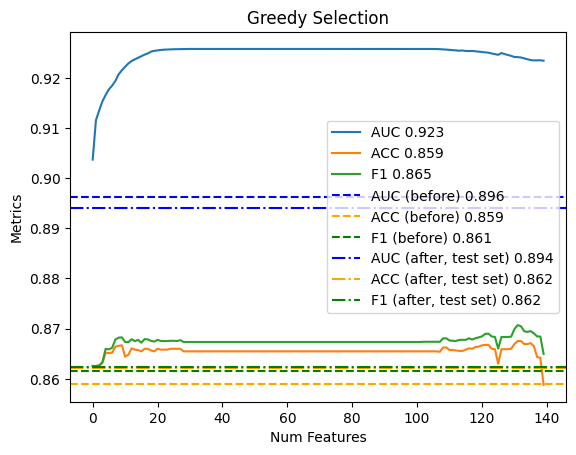

In [19]:
model = get_model_sum2con(1)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds_sum2con_seed_{seed}.csv").format(seed=seed)

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

visualize_optimization_results(model, val_loader, test_loader, greedy_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_summaries_for_atomics_False_seed_1.pt
AUC macro 0.900
ACC macro 0.860
 F1 macro 0.862
AUC macro 0.894
ACC macro 0.862
 F1 macro 0.862


  5%|▍         | 460/10000 [07:18<2:31:31,  1.05 epoch/s, Train Loss=0.49947, Val Loss=0.52628, Best Val Loss=0.52183]

Early Stopped


AUC macro 0.915
ACC macro 0.844
 F1 macro 0.851


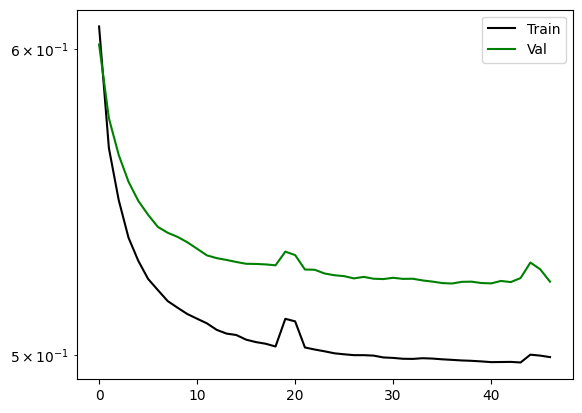

In [20]:
random_seed = 1
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds_sum2con_seed_{seed}.csv").format(seed=seed)

model = get_model_sum2con(random_seed)

model.deactivate_bottleneck_weights_if_top_k(greedy_results)
# model.opt_lr

evaluate_classification(model, test_loader)

save_path = experiment_folder + "top-k/finetuned_sum2con_seed_{seed}.pt".format(seed=random_seed)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=save_path, max_epochs=10000, patience=10)

evaluate_classification(model, test_loader)

plot_losses(model.train_losses, model.val_losses)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_summaries_for_atomics_True_seed_1.pt


AUC macro 0.913
ACC macro 0.836
 F1 macro 0.844
Found 10 Concepts
90th percentile per concept [0.17485653 0.11012712 0.15025544 0.733804   0.12479137 5.350915
 0.13964465 0.11854323 0.14277679 0.37324145]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 12', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [10.933439    0.19957875  0.18998273  0.17745395]
['Concept 0 len: 25', 'Concept 1 len: 136', 'Concept 2 len: 142', 'Concept 3 len: 133']


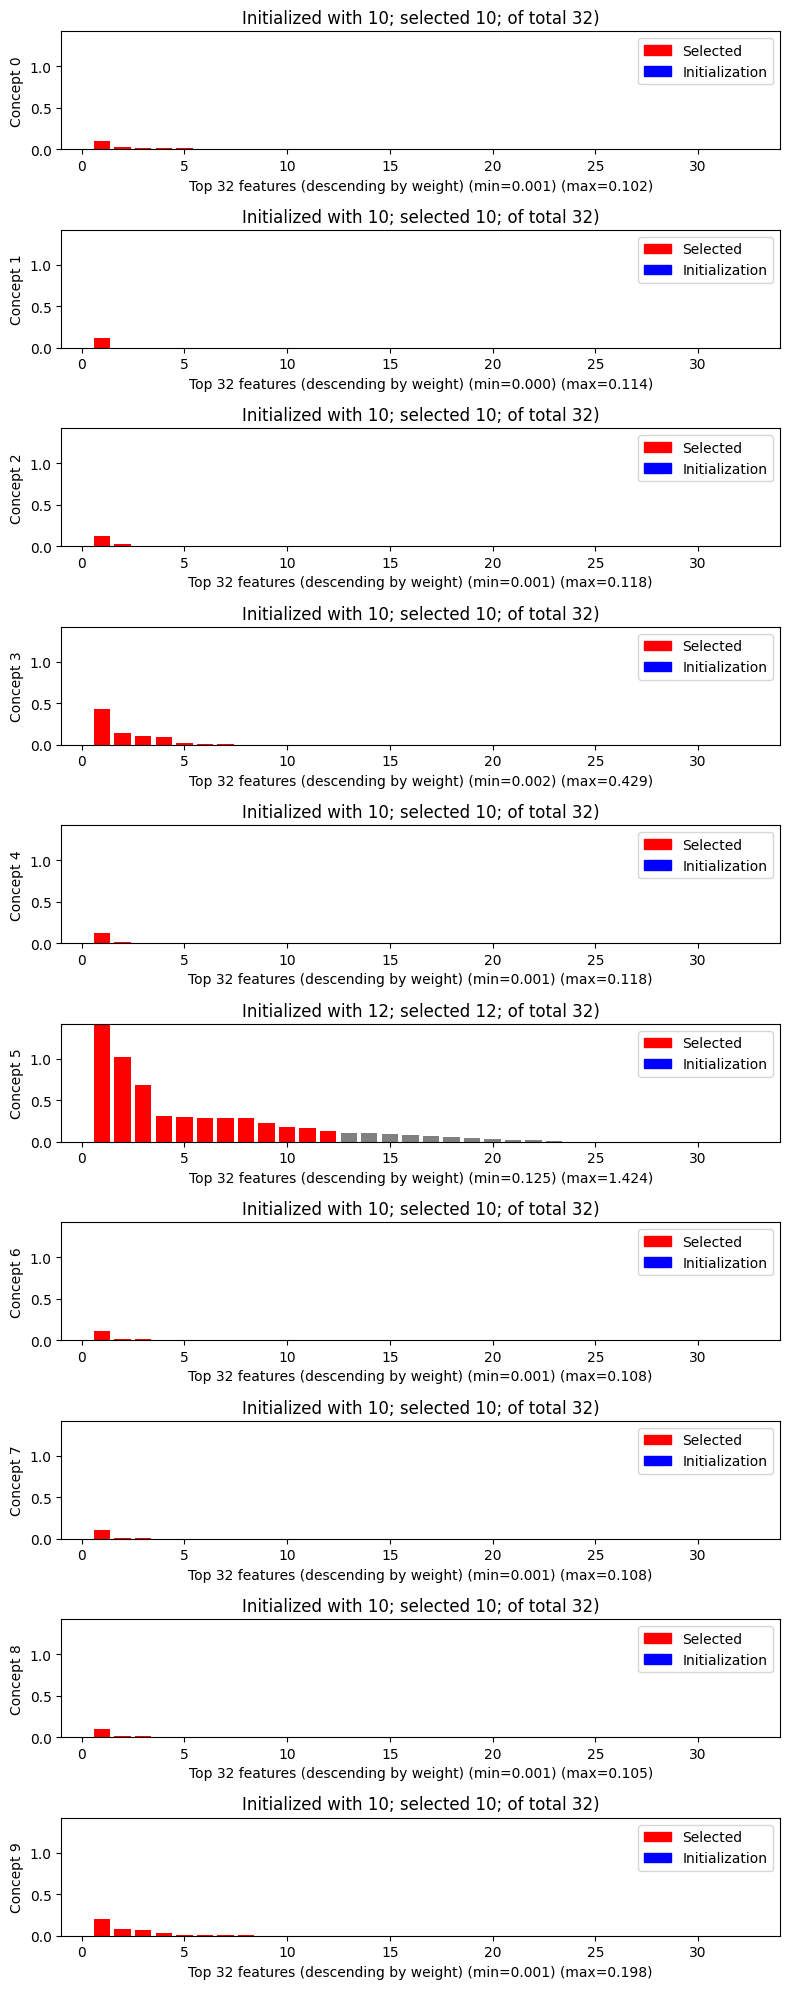

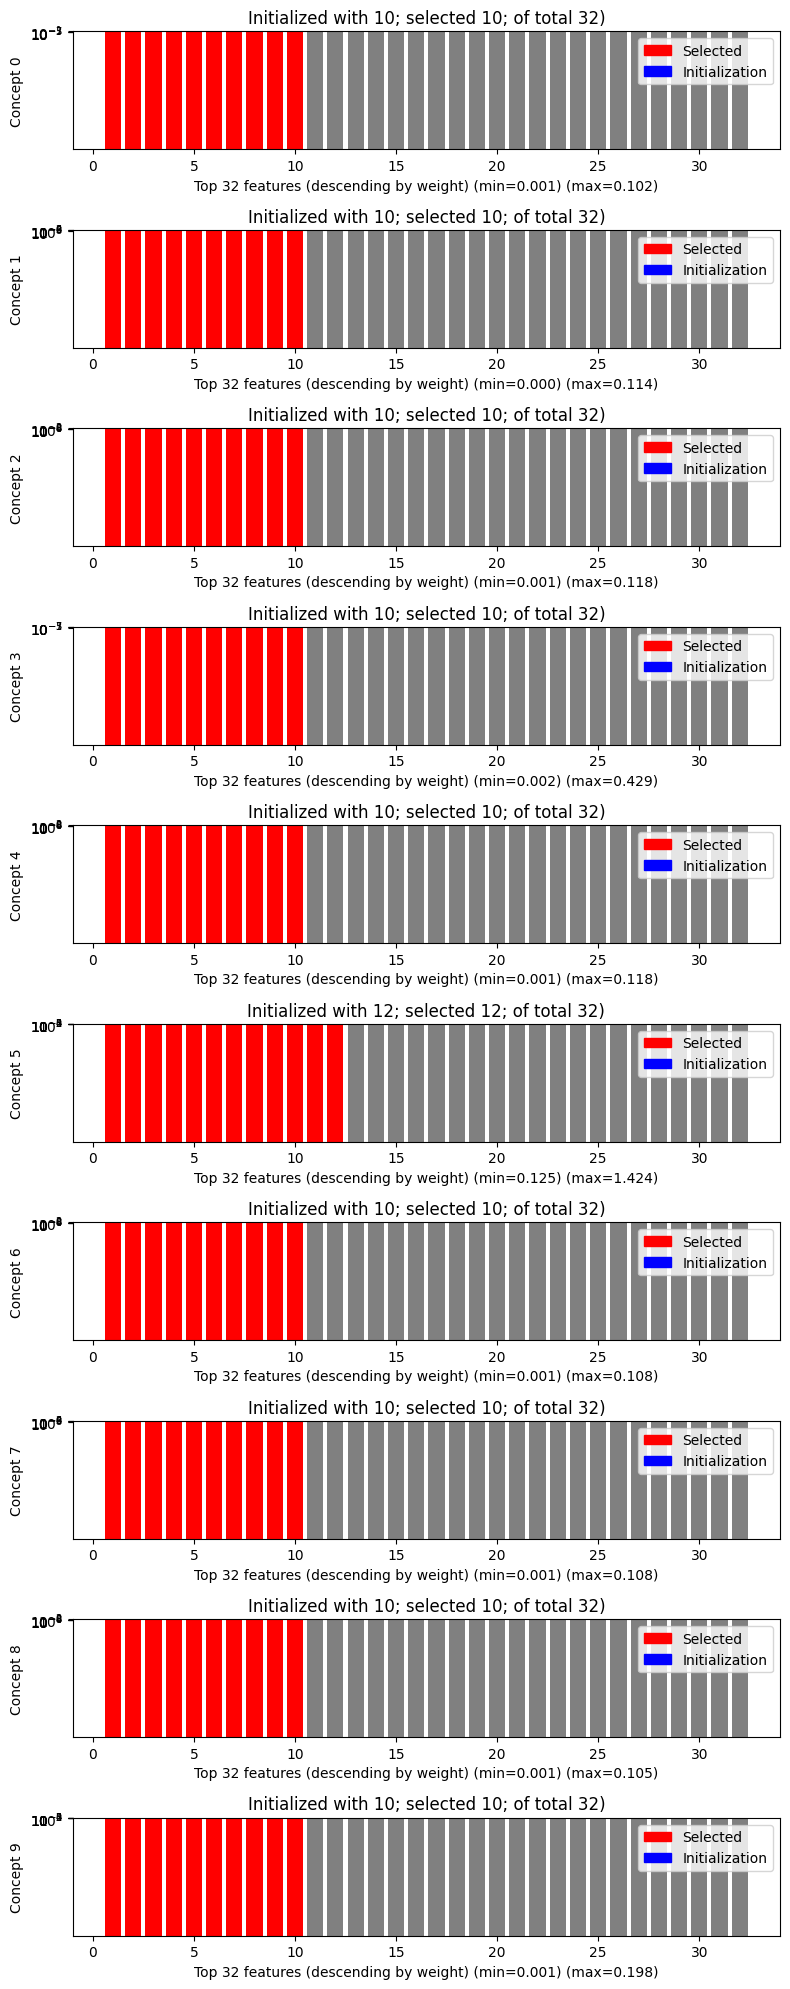

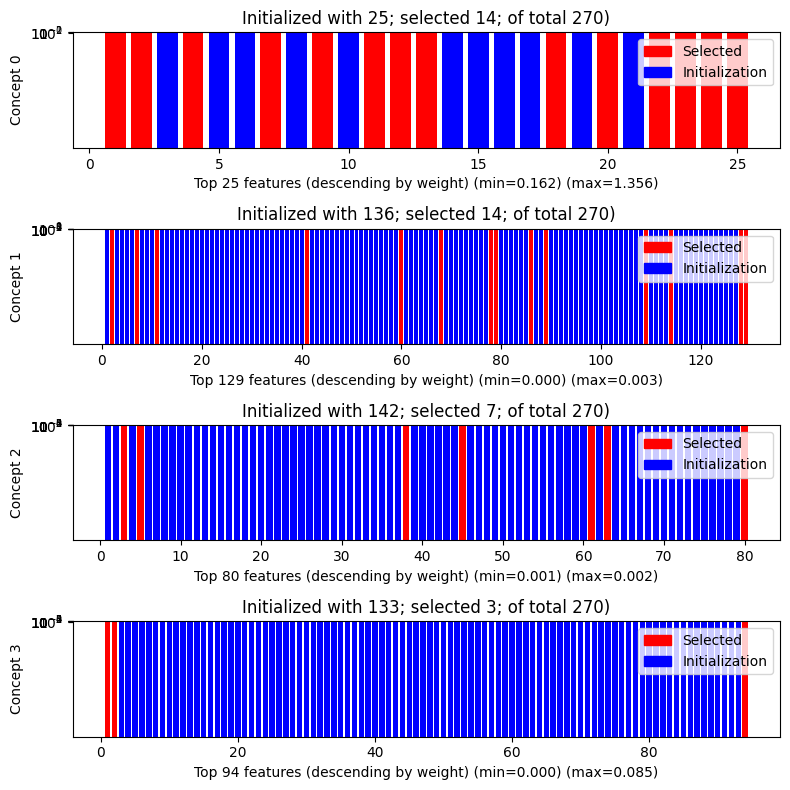

In [13]:

def plot_selected_weights(weight, top_k_inds, greedy_results, top_k=None, log_scale=True):
    abs_weight = weight.detach().cpu().numpy()
    abs_weight = np.abs(abs_weight)
    
    n_concepts = abs_weight.shape[0]
    max_y = np.max(abs_weight)
    
    fig, axs = plt.subplots(n_concepts, figsize=(8, 2 * n_concepts))
    
    for c in range(n_concepts):
        ax = axs[c]
        
        init_features_idx = top_k_inds[c]
        selected_features_idx = greedy_results[greedy_results["Concept"] == c]["Feature"].to_list()
        # print(selected_features_idx)
        
        min_weight = np.min(abs_weight[c][selected_features_idx])
        max_weight = np.max(abs_weight[c][selected_features_idx])
        
        if top_k is None:
            weight_idx = np.argsort(-abs_weight[c])
            weight_idx = weight_idx[abs_weight[c][weight_idx] >= min_weight]
        else:
            top_k = max(top_k, abs_weight.shape[1])
            weight_idx = np.argsort(-abs_weight[c])[:top_k]
        
        n_rel_feat = len(weight_idx)
        
        def getColor(idx):
            if idx in selected_features_idx:
                return "red"
            elif idx in init_features_idx:
                return "blue"
            else:
                return "gray"
        
        colors = [getColor(idx) for idx in weight_idx]
        ax.bar(np.arange(1, len(weight_idx)+1), abs_weight[c][weight_idx], color=colors)
        
        ax.set_title(f"Initialized with {len(init_features_idx)}; selected {len(selected_features_idx)}; of total {len(abs_weight[c])})")
        ax.set_xlabel(f"Top {n_rel_feat} features (descending by weight) (min={min_weight:.3f}) (max={max_weight:.3f})")
        ax.set_ylabel(f"Concept {c}")
        ax.set_ylim(0, max_y)
        if log_scale:
            ax.set_yscale('log')
        
        leg_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['red', 'blue']] # , 'gray'
        leg_labels = ["Selected", "Initialization"] # , "Ignored"
        ax.legend(leg_handles, leg_labels)
    
    # plt.ylabel("abs value of feature coefficient")
    plt.tight_layout()
    plt.show()


model = get_model_sum2atom(1)
top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
greedy_results = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds_sum2atom_seed_{seed}.csv".format(seed=random_seed) )
res1 = greedy_results[greedy_results["Layer"] == 0]
res2 = greedy_results[greedy_results["Layer"] == 1]

plot_selected_weights(model.layer_time_to_atomics.weight, top_k_inds[0], res1, top_k=300, log_scale=False)
plot_selected_weights(model.layer_time_to_atomics.weight, top_k_inds[0], res1, top_k=300, log_scale=True)
plot_selected_weights(model.layer_to_concepts.weight, top_k_inds[1], res2, top_k=None, log_scale=True)


In [10]:
pd.set_option('display.max_rows', 200)
greedy_results

,Score,Layer,Concept,Feature,acc,f1,auc
0,0.906479,0,3,22,0.137440,0.137440,0.137440
1,0.907204,0,7,17,0.137440,0.137440,0.137440
2,0.907741,0,6,21,0.137440,0.137440,0.137440
3,0.908123,0,7,21,0.137440,0.137440,0.137440
4,0.908411,0,4,17,0.137440,0.137440,0.137440
5,0.908648,0,7,16,0.137440,0.137440,0.137440
6,0.908844,0,8,30,0.137440,0.137440,0.137440
7,0.908920,0,8,17,0.137440,0.137440,0.137440
8,0.908965,0,8,11,0.137440,0.137440,0.137440
9,0.908991,0,7,30,0.137440,0.137440,0.137440


torch.Size([4, 270])